# Build deep learning tools with ImJoy and BioEngine

In this tutorial, we will demonstrate how you can interact with the BioEngine server to run cellpose segmentation, and also create graphical interface for it.


## Preparation

Here we install the libraires `kaibu-utils` for dealing with images and masks in Kaibu and `pyotritonclient` for interacting with the BioEngine server and run deep learning models (e.g. CellPose for segmentaiton).


In [30]:
import micropip
await micropip.install(["kaibu-utils", "pyotritonclient"])

In [26]:
from js import fetch
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize
from kaibu_utils import fetch_image, features_to_mask, mask_to_features
from pyotritonclient import execute

def display_image(image, mask):
    # display the output
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    ax1.imshow(image)
    ax1.set_title('input image')
    ax2.imshow(mask)
    ax2.set_title('predicted mask')
    plt.show()

def resize_image(img, size):
    assert len(size) == 2
    im = Image.fromarray(img)
    im = im.resize(size)
    return np.array(im)

async def cellpose_segment(image, diameter=100):
    results = await execute([image.transpose(2, 0, 1).astype('float32'), {'diameter': diameter}],
                server_url='https://ai.imjoy.io/triton',
                model_name='cellpose-python',
                decode_bytes=True)
    mask = results['mask'][0].copy()
    return mask


## Load an example image

(512, 512, 3)


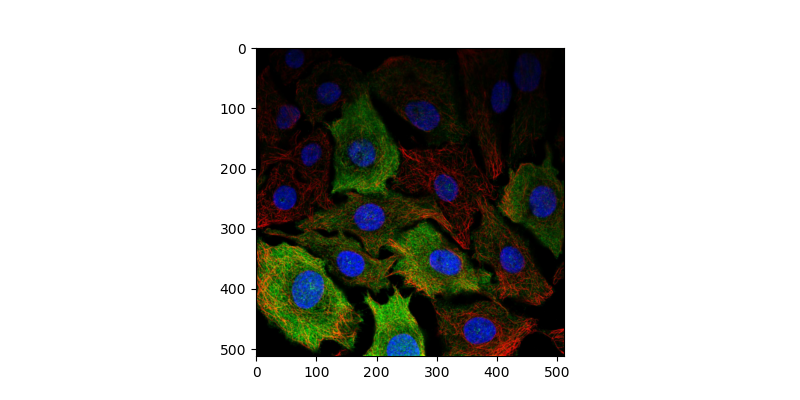

In [27]:
image = await fetch_image("https://images.proteinatlas.org/61448/1319_C10_2_blue_red_green.jpg")
image = image.astype('float32')
image = resize(image, (image.shape[0] // 4, image.shape[1] // 4), anti_aliasing=True).astype('float32')
print(image.shape)
plt.imshow(image.astype('uint8'))
plt.show()

## Use the BioEngine server to run cell segmentation

Here we use the BioEngine server to run the CellPose model

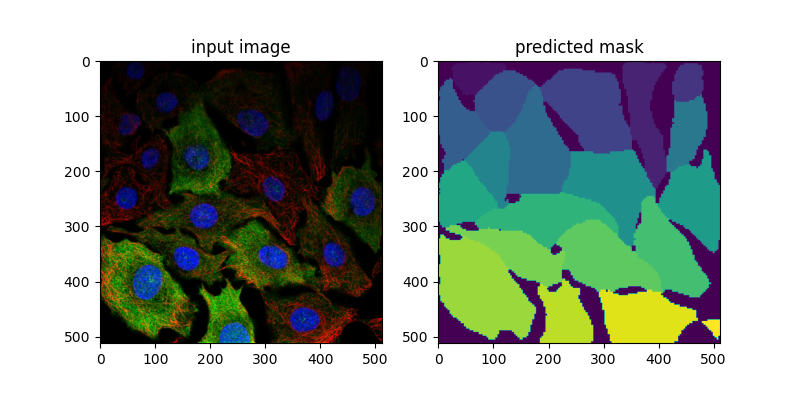

In [10]:
mask = await cellpose_segment(image, diameter=100)
display_image(image.astype('uint8'), mask)

## Create a button for run CellPose in Kaibu

In [29]:
from imjoy import api

class ImJoyPlugin():
    async def setup(self):
        viewer = await api.createWindow(src="https://kaibu.org/#/app")
        
        # Add an image layer and annotation layer
        await viewer.view_image(image.astype('uint8'))
        annotation_layer = await viewer.add_shapes([], {"name": "annotation"})
        
        async def do_segmentation():
            mask = await cellpose_segment(image)
            # await viewer.view_image(mask, name="mask")
            polygons = mask_to_features(mask)
            await viewer.add_shapes(
                polygons,
                shape_type="polygon",
                edge_color="red",
                name="prediction",
            )

        await viewer.add_widget(
        {
            "_rintf": True,
            "name": "Control",
            "type": "control",
            "elements": [
                {
                    "type": "button",
                    "label": "Do Segmentation",
                    "callback": do_segmentation,
                }
            ],
        })

api.export(ImJoyPlugin())

<IPython.core.display.Javascript object>

<_GatheringFuture pending>

## Use the BioEngine Model Runner

With the BioEngine Model runner, you can access to most of the models available at https://bioimage.io

You can pass the model id (a zenodo doi) of the model and run it through our BioEngine servers.


In [ ]:
from hypha_rpc import connect_to_server

server = await connect_to_server(
    {"name": "test client", "server_url": "https://ai.imjoy.io"}
)

triton = await server.get_service("triton-client")

In [ ]:
# Run inference with bioengine-model-runner
# With this runner you can pass any model_id that are available at https://bioimage.io to the model runner
image_array = np.random.randint(0, 255, size=(1, 1, 256, 256), dtype=np.uint8)
kwargs = {"inputs": [image_array], "model_id": "10.5281/zenodo.5869899"} # <=========== here you can pass the model id from bioimage.io
ret = await triton.execute(
    inputs=[kwargs],
    model_name="bioengine-model-runner",
    serialization="imjoy",
)
result = ret["result"]
assert result["success"] == True, result["error"]
mask = result["outputs"][0]
print("Mask predicted: ", mask.shape)

## Support reading local images

Similar to the previous tutorial for Kaibu, here we use the elFinder to load local images, resize it to (512,512) (to make sure not overloading the server), then send it to the BioEngine to run prediction and display the result with Kaibu.

To allow further editing of the predicted mask, e.g. in an interactive annotation setting, we use the `mask_to_features` to convert the predicted mask image (created by the BioEngine) into GeoJSON format so Kaibu can display it and allow further editing.

In [25]:
from imjoy import api
import imageio
from imjoy_rpc.utils import open_elfinder
from kaibu_utils import features_to_mask, mask_to_features

image_masks = []

class ImJoyPlugin():
    async def setup(self):
        pass

    async def run(self, ctx):
        viewer = await api.createWindow(src="https://kaibu.org/#/app")

        async def form_submit_callback(fields):
            cell_size = float(fields['cell size'])
            try:
                await viewer.set_loader(True)
                mask = await cellpose_segment(self.img, diameter=cell_size)
                # await viewer.view_image(mask, name="mask")
                polygons = mask_to_features(mask)
                await viewer.add_shapes(
                    polygons,
                    shape_type="polygon",
                    edge_color="red",
                    name="prediction",
                )
            except Exception as exp:
                await api.alert(f"Failed to run segmentation, error: {exp}")
            finally:
                await viewer.set_loader(False)

        async def select_file_callback():
            fm = await api.showDialog(src="https://jupyter.imjoy.io/elFinder/", name="Select a File")
            selections = await fm.getSelections()
            image_path = selections[0]['path']
            image_file = open_elfinder(image_path, "rb")
            self.img = imageio.imread(image_file)
            self.img = resize_image(self.img, size=(512,512))
            await viewer.view_image(self.img, name="Image")
            self.annotation_layer = await viewer.add_shapes([], name="Annotation")
            return image_path
            
        await viewer.add_widget({
            "_rintf": True,
            "name": "My Form",
            "type": "form",
            "form_submit_callback": form_submit_callback,
            "fields": [
                {
                    "html": "<p><strong class='has-text-info'>Image Visualization Demo</strong><br>Please select an image file</p>"
                },
                {
                    "type": "button",
                    "label": "image file",
                    "callback": select_file_callback
                },
                {
                    "type": "number",
                    "label": "cell size",
                    "value": 100,
                    "isRequired": False
                },
            ],
        })
api.export(ImJoyPlugin())

<IPython.core.display.Javascript object>

<_GatheringFuture pending>

## Going further

Wonder how we can do interactive training and annotaiton? You can find an example here: https://github.com/imjoy-team/imjoy-tutorials/blob/master/2-bioengine/4-kaibu-interactive-training.ipynb

You can also find a more complete example here: https://f1000research.com/articles/10-142
